
# MTH 354 — Lab07: Classification with CNN's (due 11/13)

**Names:** Adriana  
**Collaborators (if any):** ___________________________  


> *Complete each prompt in the cells provided. Run all code cells and include plots (where requested) in your submission.*


In [50]:

# --- Setup (PyTorch) ---
import math, time, functools, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')


## Part A — Convolution *from scratch*
In this section you will **apply small kernels** to images and see how they behave.
Run the cell below to generate a simple synthetic test image (checkerboard + dot).


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

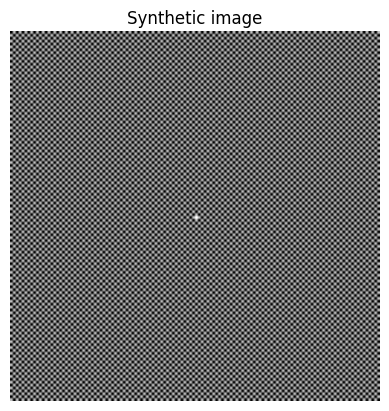

In [51]:

def synthetic_image(n=128):
    x = np.indices((n,n)).sum(axis=0) % 2  # checkerboard
    img = (x*0.6 + 0.2).astype(np.float32)
    # add a bright dot
    img[n//2, n//2] = 1.0
    return img

img = synthetic_image(128)
plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Synthetic image')
plt.axis('off')



### Apply hand-crafted kernels
Try Sobel (edges), Laplacian (second-deriv), and a blur. You can also **edit kernels**.


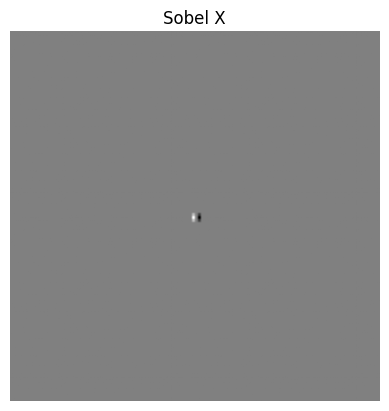

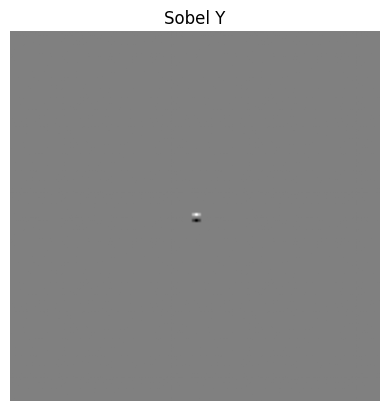

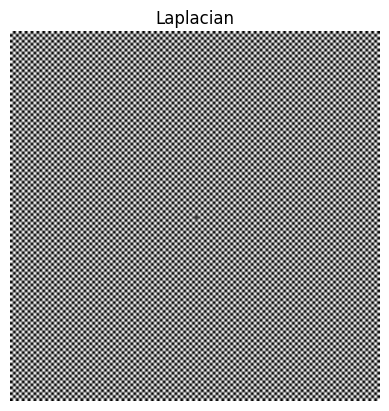

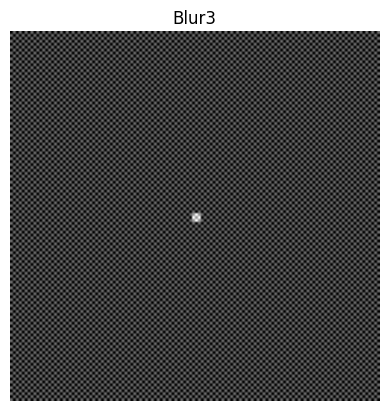

In [52]:

def apply_kernel2d(img, k):
    # valid convolution (no padding). For pedagogy; we won't optimize here.
    hi, wi = img.shape
    hk, wk = k.shape
    out = np.zeros((hi-hk+1, wi-wk+1), dtype=np.float32)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            patch = img[i:i+hk, j:j+wk]
            out[i, j] = np.sum(patch * k)
    return out

# Common kernels
sobel_x = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]], dtype=np.float32)
sobel_y = sobel_x.T
laplace = np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]], dtype=np.float32)
blur3 = np.ones((3,3), np.float32) / 9.0

for name, K in [('Sobel X', sobel_x), ('Sobel Y', sobel_y), ('Laplacian', laplace), ('Blur3', blur3)]:
    out = apply_kernel2d(img, K)
    plt.figure()
    plt.imshow(out, cmap='gray')
    plt.title(name)
    plt.axis('off')



**Exercise A1 (short answer):** In one or two sentences per kernel above, describe the visual effect you see and connect it to the kernel's numbers (e.g., why does Sobel highlight vertical edges?).  


Sobel X  highlights vertical edges because it has negative weights on the left and positive weights on the right, but the checkerboard pattern has symmetric vertical changes that cancel out under this kernel, so only the asymmetric bright dot produces a visible response.

Similarly, Sobel Y highlights horizontal edges, because it is a transpose of Sobel X, but the checkerboard pattern has symmetric vertical changes that cancel out under this kernel, so we only have a visible response for the dot in the center.

The Laplacian output shows a very fine high-frequency checkerboard pattern across the entire image, and a strong bright/dark ring around the center dot, because the Laplacian computes the second derivative, so it responds strongly to rapid intensity changes since the alternating checkerboard creates huge pixel-to-pixel jumps, and the dot creates an even larger jump, producing the bright center response.

The blur output looks like a smoothed checkerboard with much smaller contrast and a fuzzy, expanded bright spot where the center dot was, because the 3×3 blur kernel averages each pixel with its neighbors (all weights = 1/9), so the alternating bright/dark checkerboard gets averaged into mid-gray, and the sharp dot diffuses into a soft, spread-out patch.

**Exercise A2 (compute):** For a 5×5 kernel with stride 2, padding 2, input image 64×64, what is the output spatial size?

$$
H_\text{out} = \left\lfloor\frac{H_\text{in} + 2P - K}{S}\right\rfloor  + 1
=\frac{64 + 4 - 5}{2}+ 1 = 32$$


$$
W_\text{out} = \left\lfloor \frac{W_\text{in} + 2P - K}{S} \right\rfloor + 1 =\frac{64 + 4 - 5}{2}+ 1 = 32
$$


**A3 (design your own filter)**: Pick a visual pattern you want a 2D filter to emphasize on the synthetic test image and on one of the photos (e.g., a 30° diagonal ridge, a small bright “dot”/pore, a re-entrant/auxetic corner, or a coarse-scale blur). Design a $3\times3$ or $5\times5$ kernel (K) from first principles: state the target pattern, sketch the expected response, and explain your weight choices (e.g., why signs/relative magnitudes, whether $\sum K=0$ for edge/HP detectors or $\sum |K|=1$ for energy-normalized filters, and any rotation trick you used). Apply your kernel with `apply_kernel2d` to (i) the provided `synthetic_image()` and (ii) one real image; plot the outputs, and compare them to a baseline (Sobel or Laplacian). Briefly discuss what your filter captures better/worse and how the map changes if you rotate the kernel by ~15° or tweak one coefficient.

*Deliverables:* (1) your kernel matrix (K); (2) one-paragraph design rationale linking numbers → effect; (3) two annotated figures (synthetic + real) showing responses.



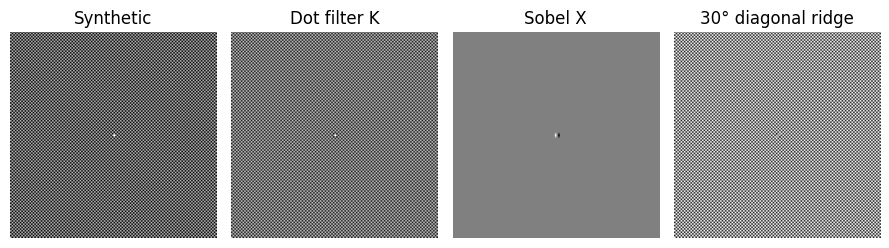

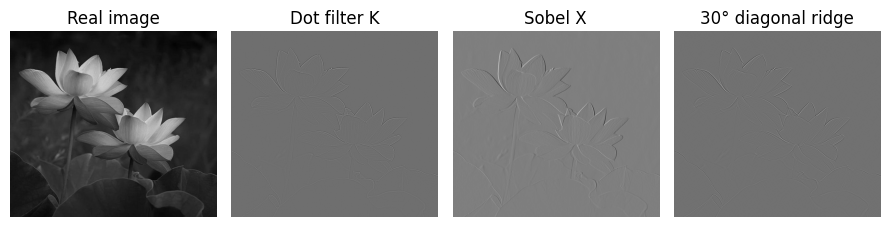

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests


# --- assumes your lab already defined these ---
#synthetic_image(n=128) and apply_kernel2d(img, K)

# 1) Define a simple dot/pore detector (3x3 Laplacian), with optional L1 normalization
K = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]], dtype=np.float32)
K = K / np.abs(K).sum()   # comment out this line if you don't want normalization

# a 30° diagonal ridge
K_30 = np.array([[-1, -1,  2],
                 [-1,  2, -1],
                 [ 2, -1, -1]], dtype=np.float32)
K_30 = K_30 / np.abs(K_30).sum()
# (optional) a baseline Sobel-X for comparison
Kx = np.array([[-1,0,1],
               [-2,0,2],
               [-1,0,1]], dtype=np.float32)

# 2) Synthetic image
img_syn = synthetic_image(128)
out_dot_syn   = apply_kernel2d(img_syn, K)
out_sobel_syn = apply_kernel2d(img_syn, Kx)
out_30 = apply_kernel2d(img_syn, K_30)

plt.figure(figsize=(9,3))
plt.subplot(1,4,1); plt.imshow(img_syn, cmap='gray');       plt.title('Synthetic');     plt.axis('off')
plt.subplot(1,4,2); plt.imshow(out_dot_syn, cmap='gray');   plt.title('Dot filter K');  plt.axis('off')
plt.subplot(1,4,3); plt.imshow(out_sobel_syn, cmap='gray'); plt.title('Sobel X');       plt.axis('off')
plt.subplot(1,4,4); plt.imshow(out_30, cmap='gray'); plt.title('30° diagonal ridge');       plt.axis('off')

plt.tight_layout(); plt.show()

# 3) Real image (provide a grayscale array called real_img)
# If you have a path, you can do:
# from PIL import Image
real_img = np.array(Image.open('/content/drive/MyDrive/image.jpg').convert('L')).astype(np.float32) / 255.0

# --- Skip if you don't have a real image yet ---
try:
    real_img
except NameError:
    real_img = img_syn  # placeholder so the cell runs

out_dot_real   = apply_kernel2d(real_img, K)
out_sobel_real = apply_kernel2d(real_img, Kx)
out_real_30 = apply_kernel2d(real_img, K_30)


plt.figure(figsize=(9,3))
plt.subplot(1,4,1); plt.imshow(real_img, cmap='gray');       plt.title('Real image');    plt.axis('off')
plt.subplot(1,4,2); plt.imshow(out_dot_real, cmap='gray');   plt.title('Dot filter K');  plt.axis('off')
plt.subplot(1,4,3); plt.imshow(out_sobel_real, cmap='gray'); plt.title('Sobel X');       plt.axis('off')
plt.subplot(1,4,4); plt.imshow(out_real_30, cmap='gray'); plt.title('30° diagonal ridge');       plt.axis('off')

plt.tight_layout(); plt.show()


The target pattern is a thin diagonal ridge at approximately 30°, going from bottom-left to top-right. The kernel places positive weights along the diagonal of the ridge and negative weights elsewhere to suppress background and off-orientation edges. The sum of the kernel is zero (∑K=0), making it a high-pass filter that emphasizes intensity changes. Relative magnitudes (2 for ridge, -1 for background) amplify ridge pixels while suppressing others. If the kernel is rotated slightly (~15°), it becomes sensitive to a slightly different ridge orientation, which can be useful for detecting ridges at various angles. The expected response is strongest where the ridge aligns with the kernel’s positive diagonal, and weak or negative elsewhere. If comparing synthetic image we can see that it produces the ridge but for the real image this filter produced very similar results as a dot filter and both are worse in comparison to the sobel X which highlights vertical edges.


## Part B — Shapes, parameters, receptive fields


In [54]:

def conv2d_out_shape(h, w, k, stride=1, pad=0, dilation=1):
    # same formula PyTorch uses
    oh = math.floor((h + 2*pad - dilation*(k-1) - 1)/stride + 1)
    ow = math.floor((w + 2*pad - dilation*(k-1) - 1)/stride + 1)
    return oh, ow

def conv2d_params(cin, cout, k):
    return cout*(cin*k*k) + cout  # weights + bias

# Demo
print('Example out shape (H,W) ->', conv2d_out_shape(64,64,k=5,stride=2,pad=2,dilation=1))
print('Example params ->', conv2d_params(cin=3, cout=16, k=3))

# TODO: compute these
# 1) Input 32x32x3, conv 3x3, stride 1, pad 1, 8 filters  -> out H,W,C? params? (H height, W width, C channels)
print('out shape (H,W) ->', conv2d_out_shape(32,32,k=3,stride=1,pad=1,dilation=1))
print('params ->', conv2d_params(cin=3, cout=8, k=3))

# 2) Stack: conv(3x3,8)->conv(3x3,16), both stride 1 pad 1 on 32x32. What is final H,W,C? total params?
print('1 layer out shape (H,W) ->', conv2d_out_shape(32,32,k=3,stride=1,pad=1,dilation=1))
print('1 layer params ->', conv2d_params(cin=3, cout=8, k=3))
print('2 layer out shape (H,W) ->', conv2d_out_shape(32,32,k=3,stride=1,pad=1,dilation=1))
print('2 layer params ->', conv2d_params(cin=8, cout=16, k=3))


Example out shape (H,W) -> (32, 32)
Example params -> 448
out shape (H,W) -> (32, 32)
params -> 224
1 layer out shape (H,W) -> (32, 32)
1 layer params -> 224
2 layer out shape (H,W) -> (32, 32)
2 layer params -> 1168



**Exercise B1 (show work):** Fill in the output sizes/parameter counts above.  
**Exercise B2 (conceptual):** Explain how stacking 3×3 convolutions increases the **effective receptive field**.


In the example stack of two convolutional layers, the first 3×3 conv with 8 filters keeps the output at 32×32 and has 224 parameters, while the second 3×3 conv with 16 filters also outputs 32×32 but with 1,168 parameters. Stacking these 3×3 layers increases the effective receptive field: each neuron in the second layer depends on a 3×3 region of the first layer, which itself depends on a 3×3 region of the input. This means the second layer effectively “sees” a 5×5 area of the original image, allowing the network to capture larger spatial patterns without increasing kernel size.


## Part C — Train a tiny CNN baseline (MNIST or FashionMNIST)
This should run in a few minutes on Colab. You can switch to `FashionMNIST` by toggling the dataset cell below.


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

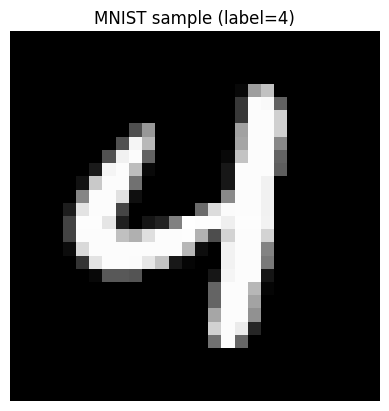

In [56]:

import torchvision, torchvision.transforms as T

ds_name = 'MNIST'  # change to 'FashionMNIST' if you like

tfm = T.Compose([T.ToTensor()])
if ds_name == 'MNIST':
    train_ds = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=tfm)
    test_ds  = torchvision.datasets.MNIST(root='./data',  train=False, download=True, transform=tfm)
else:
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=tfm)
    test_ds  = torchvision.datasets.FashionMNIST(root='./data',  train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# peek
xb, yb = next(iter(train_loader))
plt.figure();
plt.imshow(xb[0,0].numpy(), cmap='gray'); plt.title(f'{ds_name} sample (label={yb[0].item()})'); plt.axis('off')


In [57]:

class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                           # 28->14
            nn.Conv2d(8,16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                           # 14->7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*7*7, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.features(x);
        return self.classifier(x)

model = TinyCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [58]:

def accuracy(model, loader):
    model.eval()
    ncorrect = ntotal = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            ncorrect += (pred==yb).sum().item()
            ntotal   += yb.numel()
    return ncorrect/ntotal

# Train briefly (keep fast)
epochs = 3
for ep in range(1, epochs+1):
    model.train()
    t0 = time.time()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    acc = accuracy(model, test_loader)
    print(f'Epoch {ep:02d} | test acc = {acc:.3f} | time {time.time()-t0:.1f}s')


Epoch 01 | test acc = 0.957 | time 22.3s
Epoch 02 | test acc = 0.973 | time 23.5s
Epoch 03 | test acc = 0.980 | time 23.7s



## Part D — Visualize learned filters & activation maps


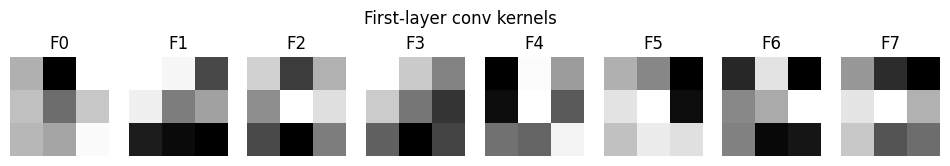

In [59]:

# Visualize first conv filters
with torch.no_grad():
    w = model.features[0].weight.cpu().numpy()  # shape (8,1,3,3)
fig, axes = plt.subplots(1, w.shape[0], figsize=(12,2))
for i in range(w.shape[0]):
    axes[i].imshow(w[i,0], cmap='gray')
    axes[i].set_title(f'F{i}'); axes[i].axis('off')
plt.suptitle('First-layer conv kernels'); plt.show()


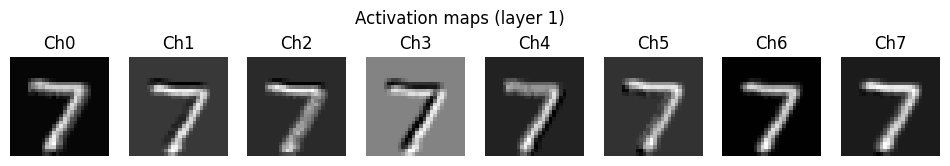

In [61]:

# Activation maps for one image
xb, yb = next(iter(test_loader))
xb = xb[:1].to(device)
acts = []

def hook_fn(module, inp, out):
    acts.append(out.detach().cpu())

h = model.features[0].register_forward_hook(hook_fn)  # after first conv
_ = model(xb)
h.remove()

act = acts[0][0]  # shape (C,H,W)
fig, axes = plt.subplots(1, min(8, act.shape[0]), figsize=(12,2))
for i in range(min(8, act.shape[0])):
    axes[i].imshow(act[i], cmap='gray')
    axes[i].set_title(f'Ch{i}'); axes[i].axis('off')
plt.suptitle('Activation maps (layer 1)'); plt.show()




**Exercise D1 (explain):** Pick two activation maps above and describe what visual patterns they respond to.  

Ch7	 map clearly highlights the sharp outlines and edges of the digit '7' while the interior is dark. This is the classic output of an edge-detecting filter.

Ch3 map strongly activates diagonal elements, such as the diagonal stroke of the '7'.



**Exercise D2 (experiment):** Remove one `MaxPool2d` (or swap it for a stride-2 conv) and report the effect on test accuracy and feature-map sizes.


In [62]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                           # 28->14
            nn.Conv2d(8,16, kernel_size=3, padding=1), nn.ReLU(),
            #nn.MaxPool2d(2),                           # 14->7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*14*14, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.features(x);
        return self.classifier(x)

model = TinyCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [63]:
def accuracy(model, loader):
    model.eval()
    ncorrect = ntotal = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            ncorrect += (pred==yb).sum().item()
            ntotal   += yb.numel()
    return ncorrect/ntotal

# Train briefly (keep fast)
epochs = 3
for ep in range(1, epochs+1):
    model.train()
    t0 = time.time()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
    acc = accuracy(model, test_loader)
    print(f'Epoch {ep:02d} | test acc = {acc:.3f} | time {time.time()-t0:.1f}s')


Epoch 01 | test acc = 0.963 | time 23.5s
Epoch 02 | test acc = 0.977 | time 22.7s
Epoch 03 | test acc = 0.981 | time 23.4s


In [64]:
xb, _ = next(iter(test_loader))
xb = xb.to(device)
x = xb
for i, layer in enumerate(model.features):
    x = layer(x)
    print(f'Layer {i}: {x.shape}')

Layer 0: torch.Size([256, 8, 28, 28])
Layer 1: torch.Size([256, 8, 28, 28])
Layer 2: torch.Size([256, 8, 14, 14])
Layer 3: torch.Size([256, 16, 14, 14])
Layer 4: torch.Size([256, 16, 14, 14])


Test accuracy:

Original TinyCNN: 0.948 -> 0.974 -> 0.980

After removing second MaxPool: 0.965 -> 0.975 -> 0.983

Observation: Test accuracy slightly improved when the second MaxPool was removed.

Removing the pooling preserves more spatial information in the feature maps, which can help the classifier make finer distinctions, especially for MNIST digits.

Removing the second MaxPool doubles the spatial size of the last feature map (7×7 → 14×14).

This increases the effective receptive field for the classifier and preserves more detailed spatial information, which explains the small gain in accuracy.


## Part E — Padding & Stride comparisons


In [65]:

def demo_shapes(H=28, W=28, k=3):
    combos = [(0,1),(1,1),(1,2),(2,2)]  # (pad,stride)
    for pad,stride in combos:
        oh, ow = conv2d_out_shape(H,W,k, stride=stride, pad=pad)
        print(f'k={k}, pad={pad}, stride={stride} -> out {oh}x{ow}')

demo_shapes()


k=3, pad=0, stride=1 -> out 26x26
k=3, pad=1, stride=1 -> out 28x28
k=3, pad=1, stride=2 -> out 14x14
k=3, pad=2, stride=2 -> out 15x15



**Exercise E1 (short answer):** Why might "same" padding be useful for deeper networks?  


Same padding keeps feature map sizes consistent across layers, which simplifies deep network design and preserves spatial information for better feature learning.

**Exercise E2 (design):** For a target receptive field of ~15×15 pixels, propose a 3-layer stack (kernel sizes/strides) that achieves it with minimal parameter count.

Using the formula $$RF_{next}​=RF_{prev}​+(k−1)\times \text{ product of strides of previous layers, and } RF_0 =1 $$

Let's chose:

Layer 1: $$5\times 5 \text{ kernel, stride=1, pad=2}$$

so RF = 1+(5-1)*1 = 5

Layer 2: $$5\times 5 \text{ kernel, stride=2, pad=2}$$
so RF = 5+(5-1)*1 = 9

Layer 3: $$4\times 4 \text{ kernel, stride=1, pad=2}$$
so RF = 9+(4-1)*2 = 15



## Reflection
In 4–6 sentences, summarize **what a conv layer learns**, how **activation maps** help us debug, and one trade-off between **stride** and **pooling** you observed.



A convolutional layer learns a set of filters that detect local visual patterns in the input, such as edges, corners, or textures. Each filter produces an activation map, which highlights where its learned pattern occurs in the image, helping us understand what the network is “looking for” and debug issues like dead filters or redundant features. Activation maps also show how feature complexity grows in deeper layers, from simple edges to more abstract shapes. One trade-off between stride and pooling is that increasing stride or using pooling reduces the spatial resolution of feature maps, which can speed up computation and enlarge the receptive field, but may lose fine-grained details and slightly decrease accuracy. Conversely, smaller strides or no pooling preserve spatial detail but increase computation and memory usage. Observing activation maps helps balance this trade-off by showing whether important patterns are still captured.

---

### AI usage statement
You may use AI tools to **rephrase** your explanations and to **debug non-substantive errors** (e.g., import issues), but all **architectural choices, analysis, and answers** must be your own. Cite any AI assistance you used.


I used ChatGPT to help me understand this syntax: import torchvision, torchvision.transforms as T

ds_name = 'MNIST'  # change to 'FashionMNIST' if you like

tfm = T.Compose([T.ToTensor()])
if ds_name == 'MNIST':
    train_ds = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=tfm)
    test_ds  = torchvision.datasets.MNIST(root='./data',  train=False, download=True, transform=tfm)
else:
    train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=tfm)
    test_ds  = torchvision.datasets.FashionMNIST(root='./data',  train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
